In [1]:
import numpy as np
import pandas as pd
import ast #for strings
import re #regex

fname='MSCI446_ Data - Sheet1.csv'

def convert_to_numpy_array(string: str):
    # Verify string is written like a python list
    stripped = string.strip()
    pattern = r"\[(.*)\]"
    match = re.match(pattern, stripped)
    if not match:
        raise NotImplementedError(f"{stripped}")
    # Group 1 captures the content inside the square brackets
    contents = match.group(1)
    
    try:
        # Use ast.literal_eval to safely evaluate string literals
        evaluated = ast.literal_eval(stripped)
        if type(evaluated) is not list:
            raise NotImplementedError()
        # series = pd.Series(evaluated)
        return np.array(evaluated)
    except (SyntaxError, ValueError):  # this occurs with the "Condition" column
        # If parsing as a list fails, split the contents within the square brackets by comma, 
        # interpret each value as a string and strip whitespace
        return np.array([ item.strip() for item in contents.split(',') ])

# Read CSV file with the custom function
numerical_vector_column_labels = ['Temperature (F)', 'Dewpoint (F)', 'Humidity (%)', 'Wind Speed (mph)', 'Pressure (in)', 'Percipitation (in)']
categorical_vector_column_labels = ["Condition"]
vector_column_labels = numerical_vector_column_labels + categorical_vector_column_labels

# Create a converters dictionary mapping each column to the converter function
converters = {col: convert_to_numpy_array for col in vector_column_labels}
df = pd.read_csv(fname, converters=converters)
df.shape

(305, 13)

In [2]:
df.head(10)

,Fire Name,Year,Season Started,Locations Affected,Temperature (F),Dewpoint (F),Humidity (%),Wind Speed (mph),Pressure (in),Percipitation (in),Condition,Type Of Location,Y-Value
0,Cagua Fire,2020,Winter,CA,"[75, 75, 73, 73, 72, 72, 71, 72, 72, 78, 82, 81]","[75, 75, 76, 76, 76, 76, 76, 76, 75, 77, 77, 77]","[85, 86, 86, 88, 90, 90, 94, 89, 74, 62, 55, 53]","[2, 3, 3, 3, 4, 4, 2, 4, 2, 4, 6, 6]","[29.8, 29.83, 29.83, 29.86, 29.86, 29.8, 29.83...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Partly Cloudy, Fair, Fair, Partly...",Mountains,Fire
1,Vietnam Fires,2019,Summer,MA,"[79, 81, 81, 82, 84, 86, 88, 90, 91, 93, 95, 97]","[72, 73, 73, 73, 73, 75, 75, 75, 75, 75, 77, 77]","[78, 79, 79, 74, 70, 70, 66, 62, 59, 56, 56, 53]","[5, 6, 2, 5, 7, 5, 5, 7, 5, 6, 5, 2]","[29.64, 29.64, 29.64, 29.64, 29.67, 29.67, 29....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Fair, Fair, Windy, Windy, Windy, ...",Coastal Hills,Fire
2,Chile Wildfires,2024,Winter,BC,"[78, 78, 78, 80, 82, 78, 77, 77, 77, 75, 73, 73]","[22, 8, 12, 19, 20, 18, 16, 13, 7, 41, 38, 22]","[74, 79, 84, 79, 74, 79, 83, 83, 83, 94, 94, 89]","[18, 18, 20, 21, 20, 20, 20, 20, 17, 10, 11, 11]","[30.09, 30.09, 30.06, 30.06, 30.06, 30.06, 30....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Partly Cloudy, Mostly Cloudy, Fair, Par...",Mountains,Fire
3,Chile Wildfires,2024,Winter,AB,"[77, 81, 84, 88, 90, 90, 88, 86, 84, 81, 79, 75]","[55, 54, 55, 54, 55, 55, 52, 54, 54, 54, 54, 54]","[47, 39, 37, 31, 31, 31, 31, 31, 35, 39, 42, 47]","[3, 6, 8, 12, 13, 15, 16, 18, 15, 15, 13, 9]","[28.31, 28.31, 28.28, 28.25, 28.25, 28.22, 28....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...",Coastal Mountain,Fire
4,Chile Wildfires,2023,Winter,MB,"[72, 73, 73, 73, 75, 77, 75, 73, 70, 68, 64, 63]","[59, 59, 59, 59, 59, 59, 57, 55, 55, 54, 52, 52]","[64, 61, 61, 57, 57, 54, 53, 53, 60, 60, 64, 68]","[13, 17, 18, 17, 21, 23, 21, 23, 18, 20, 17, 15]","[29.87, 29.84, 29.84, 29.84, 29.81, 29.81, 29....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Fair, Fair, Windy, Windy, Windy, ...",Coastal Mountain,Fire
5,Russian Wildfires,2019,Summer,ON,"[57, 59, 59, 61, 61, 61, 59, 61, 61, 63, 61, 63]","[43, 41, 41, 41, 41, 41, 39, 39, 37, 37, 37, 37]","[51, 51, 48, 48, 48, 48, 45, 42, 39, 42, 39, 39]","[11, 13, 11, 16, 18, 16, 16, 18, 16, 16, 11, 13]","[29.11, 29.11, 29.11, 29.11, 29.11, 29.11, 29....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...",Hills,Fire
6,Chilean Patagonia Wildfire,2021,Summer,YT,"[45, 45, 45, 45, 45, 43, 46, 46, 45, 45, 45, 45]","[39, 41, 41, 41, 41, 39, 37, 37, 37, 37, 37, 37]","[81, 87, 87, 87, 87, 87, 71, 71, 76, 76, 76, 76]","[23, 25, 22, 18, 21, 17, 25, 25, 29, 23, 23, 23]","[27.81, 27.86, 27.89, 27.89, 27.95, 27.92, 27....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Windy, Windy, Rain, Light Rain, Windy, Light ...",Coastal Forest,Fire
7,Chile Wildfires,2017,Winter,MA,"[84, 86, 84, 88, 86, 90, 90, 86, 84, 79, 75, 72]","[59, 61, 59, 61, 61, 63, 59, 59, 61, 57, 57, 57]","[42, 43, 42, 40, 36, 40, 45, 47, 53, 47, 53, 60]","[12, 14, 18, 15, 17, 20, 23, 24, 20, 16, 13, 9]","[29.93, 29.9, 29.9, 29.87, 29.87, 29.87, 29.84...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...",Coastal Mountain,Fire
8,Valparaiso Wildfire,2014,Spring,CA,"[50, 50, 52, 46, 48, 52, 55, 57, 61, 64, 66, 70]","[41, 41, 41, 43, 41, 43, 43, 43, 45, 45, 46, 46]","[71, 71, 71, 81, 82, 71, 63, 59, 55, 49, 49, 43]","[2, 1, 5, 2, 3, 5, 2, 1, 2, 2, 1, 5]","[28.36, 28.36, 28.36, 28.36, 28.36, 28.39, 28....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Mos...",Coastal Forest,Fire
9,Araucania Wildfire,2012,Winter,BC,"[66, 66, 68, 68, 68, 68, 66, 0, 64, 63, 63, 63]","[57, 57, 57, 59, 57, 57, 59, 0, 59, 59, 59, 59]","[73, 73, 68, 73, 68, 68, 78, 0, 83, 88, 88, 88]","[10, 14, 15, 16, 17, 13, 14, 13, 12, 9, 3, 5]","[29.93, 29.93, 29.93, 29.93, 29.93,

## Checking Data

### Categorical Encoding

In [3]:
categorical_column_labels = ["Season Started", "Locations Affected", "Condition", "Type Of Location", "Y-Value"]
categorical_scalar_column_labels = ["Season Started", "Locations Affected", "Type Of Location", "Y-Value"]

In [4]:
for cl in categorical_scalar_column_labels:
    print(df[cl].value_counts())
    print()

Summer    135
Spring     75
Fall       49
Winter     46
Name: Season Started, dtype: int64

CA      40
BC      35
AB      33
MB      25
NT      17
ON      17
YT      12
AZ       9
NM       8
FL       8
CO       8
QC       8
WA       7
TX       6
ID       6
SK       6
NY       5
OR       5
MA       5
TN       3
UT       3
SC       3
WY       3
MT       3
MN       3
DC       3
IL       3
AL       3
WC       2
PN       2
DK       2
NC       2
NJ       2
Utah     1
OK       1
MS       1
VN       1
Lyon     1
AK       1
MI       1
NF       1
Name: Locations Affected, dtype: int64

Forest              77
Mountains           60
Coastal Mountain    17
Hills               16
Coastal Forest      13
Arctic              11
Rainforest           8
Flat                 8
Grasslands           6
Plains               6
Desert               4
Coastal Hills        3
Swamp                3
Coastal Lowland      2
Coastal              1
Name: Type Of Location, dtype: int64

Fire       155
No Fire    150
Name

### Adding Vectors

In [5]:
vector_columns = df[vector_column_labels]

In [6]:
# Verifying all are ndarray
# is_ndarray = vector_columns.map(lambda x: isinstance(x, np.ndarray))
# is_ndarray.all().all()
is_ndarray = vector_columns.applymap(lambda x: isinstance(x, np.ndarray))
is_ndarray.all().all()

True

In [7]:
desired_shape = (12,)

# shape = vector_columns.map(lambda x: x.shape)
# # shape == desired_shape  # INVALID SYNTAX
# is_desired_shape = shape.map(lambda x: x == desired_shape)

shape = vector_columns.applymap(lambda x: x.shape)
# shape == desired_shape  # INVALID SYNTAX
is_desired_shape = shape.applymap(lambda x: x == desired_shape)

# Shorter version
#is_desired_shape = vector_columns.map(lambda x: x.shape == desired_shape)
is_desired_shape = vector_columns.applymap(lambda x: x.shape == desired_shape)

# Boolean series containing whether all vectors in that row are of the desired shape
valid_shape_rows = is_desired_shape.all(axis=1)

# Whether all vectors are of desired shape
is_desired_shape.all().all()

True

## Generating Stats

Generate minimum, average, and maximum values for specified columns

In [8]:
# Columns to generate stats for
columns_to_process = numerical_vector_column_labels

# Function to compute min, avg, and max and return as a Series
def compute_stats(arr):
    return pd.Series([np.min(arr), np.mean(arr), np.max(arr)], index=['min', 'avg', 'max'])

# New DataFrame to store results
num_stats_df = pd.DataFrame()

# Iterate over specified columns
for col in df.columns:
    # If the column contains numpy arrays and is in the columns to process
    if col in columns_to_process:  # and np.issubdtype(df[col].dtype, np.ndarray)
        # Compute statistics for each numpy array element in the column
        stats = df[col].apply(compute_stats)
        # Rename columns to include the statistics
        stats.columns = [f"{col}_min", f"{col}_avg", f"{col}_max"]
        # Concatenate the statistics columns with the original column and insert them into the new DataFrame
        #num_stats_df = pd.concat([num_stats_df, df[col], stats], axis=1)
        num_stats_df = pd.concat([num_stats_df, stats], axis=1)
    else:
        # If not a numpy array column or not in columns to process, copy it to the new DataFrame
        num_stats_df[col] = df[col]

num_stats_df.head(10)


,Fire Name,Year,Season Started,Locations Affected,Temperature (F)_min,Temperature (F)_avg,Temperature (F)_max,Dewpoint (F)_min,Dewpoint (F)_avg,Dewpoint (F)_max,...,Wind Speed (mph)_max,Pressure (in)_min,Pressure (in)_avg,Pressure (in)_max,Percipitation (in)_min,Percipitation (in)_avg,Percipitation (in)_max,Condition,Type Of Location,Y-Value
0,Cagua Fire,2020,Winter,CA,71.0,74.666667,82.0,75.0,76.000000,77.0,...,6.0,29.80,29.835000,29.86,0.0,0.0,0.0,"[Fair, Fair, Partly Cloudy, Fair, Fair, Partly...",Mountains,Fire
1,Vietnam Fires,2019,Summer,MA,79.0,87.250000,97.0,72.0,74.416667,77.0,...,7.0,29.64,29.652500,29.67,0.0,0.0,0.0,"[Fair, Fair, Fair, Fair, Windy, Windy, Windy, ...",Coastal Hills,Fire
2,Chile Wildfires,2024,Winter,BC,73.0,77.166667,82.0,7.0,19.666667,41.0,...,21.0,30.03,30.067500,30.09,0.0,0.0,0.0,"[Fair, Partly Cloudy, Mostly Cloudy, Fair, Par...",Mountains,Fire
3,Chile Wildfires,2024,Winter,AB,75.0,83.583333,90.0,52.0,54.166667,55.0,...,18.0,28.22,28.252500,28.31,0.0,0.0,0.0,"[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...",Coastal Mountain,Fire
4,Chile Wildfires,2023,Winter,MB,63.0,71.333333,77.0,52.0,56.583333,59.0,...,23.0,29.78,29.822500,29.87,0.0,0.0,0.0,"[Fair, Fair, Fair, Fair, Windy, Windy, Windy, ...",Coastal Mountain,Fire
5,Russian Wildfires,2019,Summer,ON,57.0,60.500000,63.0,37.0,39.500000,43.0,...,18.0,29.11,29.110000,29.11,0.0,0.0,0.0,"[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...",Hills,Fire
6,Chilean Patagonia Wildfire,2021,Summer,YT,43.0,45.000000,46.0,37.0,38.666667,41.0,...,29.0,27.81,27.883333,27.95,0.0,0.0,0.0,"[Windy, Windy, Rain, Light Rain, Windy, Light ...",Coastal Forest,Fire
7,Chile Wildfires,2017,Winter,MA,72.0,83.666667,90.0,57.0,59.500000,63.0,...,24.0,29.84,29.872500,29.93,0.0,0.0,0.0,"[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Fai...",Coastal Mountain,Fire
8,Valparaiso Wildfire,2014,Spring,CA,46.0,55.916667,70.0,41.0,43.166667,46.0,...,5.0,28.33,28.367500,28.39,0.0,0.0,0.0,"[Fair, Fair, Fair, Fair, Fair, Fair, Fair, Mos...",Coastal Forest,Fire
9,Araucania Wildfire,2012,Winter,BC,0.0,60.250000,68.0,0.0,53.250000,59.0,...,17.0,0.00,27.420833,29.93,0.0,0.0,0.0,"[Cloudy, Cloudy, Mostly Cloudy, Mostly Cloudy,...",Coastal Forest,Fire


## Data Preparation

### Dealing with missing values

Checking element values

In [9]:
# Only select for columns where we care if values are missing (do not care if we are missing Fire Name)
na_rows = df[df.isna().any(axis=1)]

# Iterate over rows with NaN values
for index, row in na_rows.iterrows():
    # Check if 'Fire Name' column is NaN, and if so, replace with 'Non Fire'
    if pd.isna(row['Fire Name']):
        df.at[index, 'Fire Name'] = 'Non Fire'
    # Check if 'Type of Location' column is NaN, and if so, replace with 'Forest'
    if pd.isna(row['Type Of Location']):
        df.at[index, 'Type Of Location'] = 'Forest'

print(df)

           Fire Name  Year Season Started Locations Affected  \
0         Cagua Fire  2020         Winter                 CA   
1      Vietnam Fires  2019         Summer                 MA   
2    Chile Wildfires  2024         Winter                 BC   
3    Chile Wildfires  2024         Winter                 AB   
4    Chile Wildfires  2023         Winter                 MB   
..               ...   ...            ...                ...   
300         Non Fire  2020         Summer                 MB   
301         Non Fire  2020         Summer                 MB   
302         Non Fire  2020           Fall                 MB   
303         Non Fire  2020         Summer                 NT   
304         Non Fire  2020         Summer                 NT   

                                      Temperature (F)  \
0    [75, 75, 73, 73, 72, 72, 71, 72, 72, 78, 82, 81]   
1    [79, 81, 81, 82, 84, 86, 88, 90, 91, 93, 95, 97]   
2    [78, 78, 78, 80, 82, 78, 77, 77, 77, 75, 73, 73]   
3  

In [10]:
na_rows_2 = num_stats_df[num_stats_df.isna().any(axis=1)]

# Iterate over rows with NaN values
for index, row in na_rows_2.iterrows():
    # Check if 'Fire Name' column is NaN, and if so, replace with 'Non Fire'
    if pd.isna(row['Fire Name']):
        num_stats_df.at[index, 'Fire Name'] = 'Non Fire'
    # Check if 'Type of Location' column is NaN, and if so, replace with 'Forest'
    if pd.isna(row['Type Of Location']):
        num_stats_df.at[index, 'Type Of Location'] = 'Forest'

print(num_stats_df)

           Fire Name  Year Season Started Locations Affected  \
0         Cagua Fire  2020         Winter                 CA   
1      Vietnam Fires  2019         Summer                 MA   
2    Chile Wildfires  2024         Winter                 BC   
3    Chile Wildfires  2024         Winter                 AB   
4    Chile Wildfires  2023         Winter                 MB   
..               ...   ...            ...                ...   
300         Non Fire  2020         Summer                 MB   
301         Non Fire  2020         Summer                 MB   
302         Non Fire  2020           Fall                 MB   
303         Non Fire  2020         Summer                 NT   
304         Non Fire  2020         Summer                 NT   

     Temperature (F)_min  Temperature (F)_avg  Temperature (F)_max  \
0                   71.0            74.666667                 82.0   
1                   79.0            87.250000                 97.0   
2                   7

Checking contents for numpy arrays (numerical only)

In [11]:
na_rows = df[df.isna().any(axis=1)]
na_rows_2 = num_stats_df[num_stats_df.isna().any(axis=1)]
na_rows, na_rows_2

(Empty DataFrame
 Columns: [Fire Name, Year, Season Started, Locations Affected, Temperature (F), Dewpoint (F), Humidity (%), Wind Speed (mph), Pressure (in), Percipitation (in), Condition, Type Of Location, Y-Value]
 Index: [],
 Empty DataFrame
 Columns: [Fire Name, Year, Season Started, Locations Affected, Temperature (F)_min, Temperature (F)_avg, Temperature (F)_max, Dewpoint (F)_min, Dewpoint (F)_avg, Dewpoint (F)_max, Humidity (%)_min, Humidity (%)_avg, Humidity (%)_max, Wind Speed (mph)_min, Wind Speed (mph)_avg, Wind Speed (mph)_max, Pressure (in)_min, Pressure (in)_avg, Pressure (in)_max, Percipitation (in)_min, Percipitation (in)_avg, Percipitation (in)_max, Condition, Type Of Location, Y-Value]
 Index: []
 
 [0 rows x 25 columns])

### Dealing with categorical data

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
# unencoded_df = df.copy(deep=True)

# mapping_dict = {'BC': 'British Columbia', 'YT': 'Yukon', 'QC': 'Quebec', 'AB': 'Alberta', 'MB': 'Manitoba', 'ON': 'Ontario', 'CA': 'California'}
# def pain(x) -> str:
#     # create a temporary list to hold the replaced strings
#     temp = []
#     for word in str(x).split():
#         temp.append(mapping_dict.get(word, word))
     
#     # join the temporary list to create the final output string
#     res = " ".join(temp)
#     # print(temp, res)
#     return str(res)

# # Columns containing single categorical values
# for cl in categorical_scalar_column_labels:
#     if cl == 'Locations Affected':
#         # print(unencoded_df['Locations Affected'].value_counts())
#         df[cl] = df[cl].apply(pain)
#         pass
#     df[cl] = le.fit_transform(df[cl])

# print(df['Condition'])

# # Columns containing categorical vector values
# for cl in categorical_vector_column_labels:
#     le.fit(np.concatenate(df['Condition'].values))
#     # le.fit_transform(df['Condition'])
#     df[cl] = df[cl].apply(le.transform)
# # print(df['Y-Value'].value_counts())
print(df['Y-Value'].value_counts())
print(df['Locations Affected'].value_counts())
print(num_stats_df['Y-Value'].value_counts())
print(num_stats_df['Locations Affected'].value_counts())

Fire       155
No Fire    150
Name: Y-Value, dtype: int64
CA      40
BC      35
AB      33
MB      25
NT      17
ON      17
YT      12
AZ       9
NM       8
FL       8
CO       8
QC       8
WA       7
TX       6
ID       6
SK       6
NY       5
OR       5
MA       5
TN       3
UT       3
SC       3
WY       3
MT       3
MN       3
DC       3
IL       3
AL       3
WC       2
PN       2
DK       2
NC       2
NJ       2
Utah     1
OK       1
MS       1
VN       1
Lyon     1
AK       1
MI       1
NF       1
Name: Locations Affected, dtype: int64
Fire       155
No Fire    150
Name: Y-Value, dtype: int64
CA      40
BC      35
AB      33
MB      25
NT      17
ON      17
YT      12
AZ       9
NM       8
FL       8
CO       8
QC       8
WA       7
TX       6
ID       6
SK       6
NY       5
OR       5
MA       5
TN       3
UT       3
SC       3
WY       3
MT       3
MN       3
DC       3
IL       3
AL       3
WC       2
PN       2
DK       2
NC       2
NJ       2
Utah     1
OK       1
MS       

### Dealing with Outliers

TBD

### Partitioning a data set

Cross Validation

In [14]:
# Replace y value
# with pd.option_context('future.no_silent_downcasting', True):
fire_map = {'Fire': 1, 'Fire\r\n': 1, 'No Fire': 0, 'Not Fire': 0}
#     coded_df = pd.DataFrame()
#     coded_df['Y-Value_encoded'] = unencoded_df['Y-Value'].replace(fire_map).astype(int)
#     coded_df['Y-Value_encoded'].value_counts()
df['Y-Value'] = df['Y-Value'].replace(fire_map)
num_stats_df['Y-Value'] = num_stats_df['Y-Value'].replace(fire_map)
print(df['Y-Value'].value_counts())
print(df['Locations Affected'].value_counts())
print(num_stats_df['Y-Value'].value_counts())
print(num_stats_df['Locations Affected'].value_counts())

1    155
0    150
Name: Y-Value, dtype: int64
CA      40
BC      35
AB      33
MB      25
NT      17
ON      17
YT      12
AZ       9
NM       8
FL       8
CO       8
QC       8
WA       7
TX       6
ID       6
SK       6
NY       5
OR       5
MA       5
TN       3
UT       3
SC       3
WY       3
MT       3
MN       3
DC       3
IL       3
AL       3
WC       2
PN       2
DK       2
NC       2
NJ       2
Utah     1
OK       1
MS       1
VN       1
Lyon     1
AK       1
MI       1
NF       1
Name: Locations Affected, dtype: int64
1    155
0    150
Name: Y-Value, dtype: int64
CA      40
BC      35
AB      33
MB      25
NT      17
ON      17
YT      12
AZ       9
NM       8
FL       8
CO       8
QC       8
WA       7
TX       6
ID       6
SK       6
NY       5
OR       5
MA       5
TN       3
UT       3
SC       3
WY       3
MT       3
MN       3
DC       3
IL       3
AL       3
WC       2
PN       2
DK       2
NC       2
NJ       2
Utah     1
OK       1
MS       1
VN       1
Lyon     1


In [15]:
# # Replace seasons
indicator = pd.get_dummies(df['Season Started'], prefix='Season_Started')
indicator_stats = pd.get_dummies(num_stats_df['Season Started'], prefix='Season_Started')
# indicator, indicator_stats
df = df.drop(['Season Started'], axis=1)
df = df.join(indicator)
num_stats_df = num_stats_df.join(indicator_stats)
num_stats_df = num_stats_df.drop(['Season Started'], axis=1)
df.head(10), num_stats_df.head(10)

(                    Fire Name  Year Locations Affected  \
 0                  Cagua Fire  2020                 CA   
 1               Vietnam Fires  2019                 MA   
 2             Chile Wildfires  2024                 BC   
 3             Chile Wildfires  2024                 AB   
 4             Chile Wildfires  2023                 MB   
 5           Russian Wildfires  2019                 ON   
 6  Chilean Patagonia Wildfire  2021                 YT   
 7             Chile Wildfires  2017                 MA   
 8         Valparaiso Wildfire  2014                 CA   
 9          Araucania Wildfire  2012                 BC   
 
                                     Temperature (F)  \
 0  [75, 75, 73, 73, 72, 72, 71, 72, 72, 78, 82, 81]   
 1  [79, 81, 81, 82, 84, 86, 88, 90, 91, 93, 95, 97]   
 2  [78, 78, 78, 80, 82, 78, 77, 77, 77, 75, 73, 73]   
 3  [77, 81, 84, 88, 90, 90, 88, 86, 84, 81, 79, 75]   
 4  [72, 73, 73, 73, 75, 77, 75, 73, 70, 68, 64, 63]   
 5  [57, 59, 

In [16]:
# Locations Affected
indicator_new = pd.get_dummies(df['Locations Affected'], prefix='Locations_Affected')
indicator_stats_new = pd.get_dummies(num_stats_df['Locations Affected'], prefix='Locations_Affected')
# indicator, indicator_stats
df = df.drop(['Locations Affected'], axis=1)
df = df.join(indicator_new)
num_stats_df = num_stats_df.join(indicator_stats_new)
num_stats_df = num_stats_df.drop(['Locations Affected'], axis=1)
#df.head(10), num_stats_df.head(10)
df.columns.tolist()

['Fire Name',
 'Year',
 'Temperature (F)',
 'Dewpoint (F)',
 'Humidity (%)',
 'Wind Speed (mph)',
 'Pressure (in)',
 'Percipitation (in)',
 'Condition',
 'Type Of Location',
 'Y-Value',
 'Season_Started_Fall',
 'Season_Started_Spring',
 'Season_Started_Summer',
 'Season_Started_Winter',
 'Locations_Affected_AB',
 'Locations_Affected_AK',
 'Locations_Affected_AL',
 'Locations_Affected_AZ',
 'Locations_Affected_BC',
 'Locations_Affected_CA',
 'Locations_Affected_CO',
 'Locations_Affected_DC',
 'Locations_Affected_DK',
 'Locations_Affected_FL',
 'Locations_Affected_ID',
 'Locations_Affected_IL',
 'Locations_Affected_Lyon',
 'Locations_Affected_MA',
 'Locations_Affected_MB',
 'Locations_Affected_MI',
 'Locations_Affected_MN',
 'Locations_Affected_MS',
 'Locations_Affected_MT',
 'Locations_Affected_NC',
 'Locations_Affected_NF',
 'Locations_Affected_NJ',
 'Locations_Affected_NM',
 'Locations_Affected_NT',
 'Locations_Affected_NY',
 'Locations_Affected_OK',
 'Locations_Affected_ON',
 'Locati

In [17]:
# Type Of Location
indicator_new_loc = pd.get_dummies(df['Type Of Location'], prefix='Type_Of_Location')
indicator_stats_new_loc = pd.get_dummies(num_stats_df['Type Of Location'], prefix='Type_Of_Location')
# indicator, indicator_stats
df = df.drop(['Type Of Location'], axis=1)
df = df.join(indicator_new_loc)
num_stats_df = num_stats_df.join(indicator_stats_new_loc)
num_stats_df = num_stats_df.drop(['Type Of Location'], axis=1)
#df.head(10), num_stats_df.head(10)
df.columns.tolist()


['Fire Name',
 'Year',
 'Temperature (F)',
 'Dewpoint (F)',
 'Humidity (%)',
 'Wind Speed (mph)',
 'Pressure (in)',
 'Percipitation (in)',
 'Condition',
 'Y-Value',
 'Season_Started_Fall',
 'Season_Started_Spring',
 'Season_Started_Summer',
 'Season_Started_Winter',
 'Locations_Affected_AB',
 'Locations_Affected_AK',
 'Locations_Affected_AL',
 'Locations_Affected_AZ',
 'Locations_Affected_BC',
 'Locations_Affected_CA',
 'Locations_Affected_CO',
 'Locations_Affected_DC',
 'Locations_Affected_DK',
 'Locations_Affected_FL',
 'Locations_Affected_ID',
 'Locations_Affected_IL',
 'Locations_Affected_Lyon',
 'Locations_Affected_MA',
 'Locations_Affected_MB',
 'Locations_Affected_MI',
 'Locations_Affected_MN',
 'Locations_Affected_MS',
 'Locations_Affected_MT',
 'Locations_Affected_NC',
 'Locations_Affected_NF',
 'Locations_Affected_NJ',
 'Locations_Affected_NM',
 'Locations_Affected_NT',
 'Locations_Affected_NY',
 'Locations_Affected_OK',
 'Locations_Affected_ON',
 'Locations_Affected_OR',
 'L

In [18]:
# Conditions
df_cur = pd.get_dummies(df['Condition'].apply(pd.Series).stack(), prefix='Condition_').groupby(level=0).sum()
num_stats_df_cr = pd.get_dummies(num_stats_df['Condition'].apply(pd.Series).stack(), prefix='Condition_').groupby(level=0).sum()
df = pd.concat([df, df_cur], axis=1)
num_stats_df = pd.concat([num_stats_df, num_stats_df_cr], axis=1)
df.columns.tolist(), num_stats_df.columns.tolist()


(['Fire Name',
  'Year',
  'Temperature (F)',
  'Dewpoint (F)',
  'Humidity (%)',
  'Wind Speed (mph)',
  'Pressure (in)',
  'Percipitation (in)',
  'Condition',
  'Y-Value',
  'Season_Started_Fall',
  'Season_Started_Spring',
  'Season_Started_Summer',
  'Season_Started_Winter',
  'Locations_Affected_AB',
  'Locations_Affected_AK',
  'Locations_Affected_AL',
  'Locations_Affected_AZ',
  'Locations_Affected_BC',
  'Locations_Affected_CA',
  'Locations_Affected_CO',
  'Locations_Affected_DC',
  'Locations_Affected_DK',
  'Locations_Affected_FL',
  'Locations_Affected_ID',
  'Locations_Affected_IL',
  'Locations_Affected_Lyon',
  'Locations_Affected_MA',
  'Locations_Affected_MB',
  'Locations_Affected_MI',
  'Locations_Affected_MN',
  'Locations_Affected_MS',
  'Locations_Affected_MT',
  'Locations_Affected_NC',
  'Locations_Affected_NF',
  'Locations_Affected_NJ',
  'Locations_Affected_NM',
  'Locations_Affected_NT',
  'Locations_Affected_NY',
  'Locations_Affected_OK',
  'Locations_Af

### KNN

In [19]:
# KNN Find K from Bootstrap + CV
# Initialize lists to store mean accuracy for each K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

mean_accuracies = []
num_stats_df.columns.tolist()
column_types = num_stats_df.dtypes
# print("Data types of each column:")
# print(column_types)
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#Perform bootstrapping and cross-validation for each K
for k in k_values:
    accuracies = []
    for _ in range(100):  # Perform bootstrapping with replacement 100 times
        # Generate random indices for bootstrapping
        target_var = 'Y-Value'
        num_stats_df.columns.tolist()
        
        # Determining Train Test Indices with Bootstrap
        df_bootstrapped = num_stats_df.sample(n=len(num_stats_df), replace=True)
        X = df_bootstrapped.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
        y = df_bootstrapped[target_var]
        
        # Create KNN classifier with current K
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Perform cross-validation
        scores = cross_val_score(knn, X, y, cv=5)
        
        # Calculate mean accuracy and store
        accuracies.append(scores.mean())
    
    # Calculate mean accuracy across bootstraps for current K
    mean_accuracies.append(np.mean(accuracies))

# Find the best K based on mean accuracy
for acc in mean_accuracies:
    print("ACC: ", acc)
best_k = k_values[np.argmax(mean_accuracies)]
print("Best K: ", best_k)


ACC:  0.8717049180327869
ACC:  0.8152131147540984
ACC:  0.8101311475409836
ACC:  0.789049180327869
ACC:  0.7865901639344259
ACC:  0.7783934426229508
ACC:  0.785016393442623
ACC:  0.7760983606557378
ACC:  0.7739672131147541
Best K:  1


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn import metrics

target_var = 'Y-Value'
# Determining Train Test Indices with Bootstrap
X = num_stats_df.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
y = num_stats_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# Create KNN classifier with current K
knn = KNeighborsClassifier(n_neighbors=best_k)

knn1_pred = knn.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")
print('MSE of KNN: ', metrics.mean_squared_error(knn1_pred, y_test))
# Calculate mean accuracy and store
acc = metrics.accuracy_score(y_test,knn1_pred)
print('The accuracy of logistic regression model is ', acc)

print('Precision:', metrics.precision_score(y_test, knn1_pred))
print('Recall:', metrics.recall_score(y_test, knn1_pred))
print('Accuracy:', metrics.accuracy_score(y_test, knn1_pred))
print('F1:', metrics.f1_score(y_test, knn1_pred))
print(metrics.classification_report(y_test, knn1_pred))
confusion_table(y_test, knn1_pred)

MSE of KNN:  0.2459016393442623
The accuracy of logistic regression model is  0.7540983606557377
Precision: 0.8076923076923077
Recall: 0.6774193548387096
Accuracy: 0.7540983606557377
F1: 0.7368421052631579
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        30
           1       0.81      0.68      0.74        31

    accuracy                           0.75        61
   macro avg       0.76      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61



Truth,0,1
Predicted,,
0,25,5
1,10,21


### Logistic Regression

In [21]:
# Logistic Regression
# Initialize lists to store mean accuracy for each K
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
target_var = 'Y-Value'
X = num_stats_df.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
y = num_stats_df[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression(max_iter=1000)

# Fit the model
model = model.fit(X_train_scaled, y_train)


# Predict on test set
prediction = model.predict(X_test_scaled)

# Calculate accuracy
print('MSE of logistic regression: ', metrics.mean_squared_error(prediction, y_test))
confusion_table(prediction, y_test)
print('Precision:', metrics.precision_score(y_test, prediction))
print('Recall:', metrics.recall_score(y_test, prediction))
print('Accuracy:', metrics.accuracy_score(y_test, prediction))
print('F1:', metrics.f1_score(y_test, prediction))
print(metrics.classification_report(y_test, prediction))
confusion_table(y_test, prediction)

MSE of logistic regression:  0.16393442622950818
Precision: 0.8620689655172413
Recall: 0.8064516129032258
Accuracy: 0.8360655737704918
F1: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.81      0.83        31

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



Truth,0,1
Predicted,,
0,26,4
1,6,25


### Support Vector Machines


In [22]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

scaler = StandardScaler()
target_var = 'Y-Value'
best_score = 0
best_params = {}

# Linear SVC
for C in [0.001,0.01,0.1,1,5,10,100]:
    scores = []
    settings = {'kernel': 'linear', 'C': C}
    for _ in range(10):

        df_bootstrapped = num_stats_df.sample(n=len(num_stats_df), replace=True)
        X = df_bootstrapped.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
        y = df_bootstrapped[target_var]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        svm_lin = SVC(kernel='linear', C=C)
        svm_lin.fit(X_train, y_train)
        lin_pred = svm_lin.predict(X_test)
        scores.append(accuracy_score(y_test, lin_pred))
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_params = settings.copy()

# Poly SVC
for C in [0.001,0.01,0.1,1,5,10,100]:
    for d in range(len(num_stats_df.columns)):
        scores = []
        settings = {'kernel': 'poly', 'C': C, 'degree': d}
        for _ in range(10):
            df_bootstrapped = num_stats_df.sample(n=len(num_stats_df), replace=True)
            X = df_bootstrapped.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
            y = df_bootstrapped[target_var]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            svm_poly = SVC(kernel='poly', C=C, degree=d)
            svm_poly.fit(X_train, y_train)
            poly_pred = svm_poly.predict(X_test)
            scores.append(accuracy_score(y_test, poly_pred))
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = settings.copy()

# RBF SVC
for C in [0.001,0.01,0.1,1,5,10,100]:
    for g in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        scores = []
        settings = {'kernel': 'rbf', 'C': C, 'gamma': g}
        for _ in range(10):
            df_bootstrapped = num_stats_df.sample(n=len(num_stats_df), replace=True)
            X = df_bootstrapped.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
            y = df_bootstrapped[target_var]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            svm_rbf = SVC(kernel='rbf', C=C, gamma=g)
            svm_rbf.fit(X_train, y_train)
            rbf_pred = svm_rbf.predict(X_test)
            scores.append(accuracy_score(y_test, rbf_pred))
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = settings.copy()

print("Best SVM parameters:", best_params)
print("Best accuracy score:", best_score)


Best SVM parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
Best accuracy score: 0.881967213114754


In [23]:
# Using our best Accuracy score for SVM, we will build out the SVM with our non-bootstrapped data
scaler = StandardScaler()
target_var = 'Y-Value'
X = num_stats_df.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
y = num_stats_df[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model_svm = SVC(kernel='rbf', C=5, gamma=0.001)
model_svm.fit(X_train, y_train)
predict_svm = model_svm.predict(X_test)

# Calculate accuracy
acc = metrics.accuracy_score(y_test, predict_svm)
print('The accuracy of logistic regression model is ', acc)

print('Precision:', metrics.precision_score(y_test, predict_svm))
print('Recall:', metrics.recall_score(y_test, predict_svm))
print('Accuracy:', metrics.accuracy_score(y_test, predict_svm))
print('F1:', metrics.f1_score(y_test, predict_svm))
print(metrics.classification_report(y_test, predict_svm))
confusion_table(y_test, predict_svm)

The accuracy of logistic regression model is  0.7540983606557377
Precision: 0.7857142857142857
Recall: 0.7096774193548387
Accuracy: 0.7540983606557377
F1: 0.7457627118644068
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        30
           1       0.79      0.71      0.75        31

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



Truth,0,1
Predicted,,
0,24,6
1,9,22


### Confusion matrix

KNN
Logistic
SVM


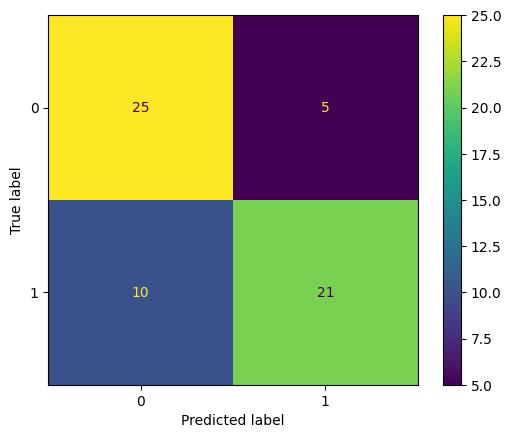

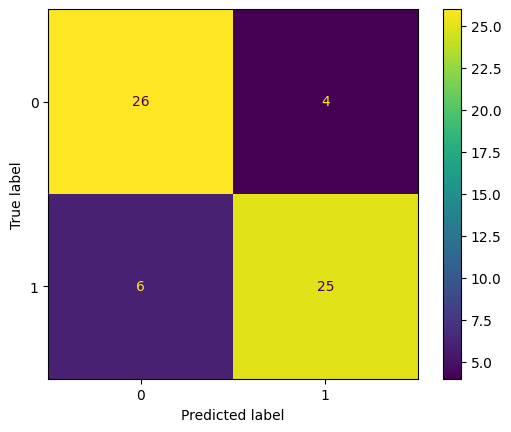

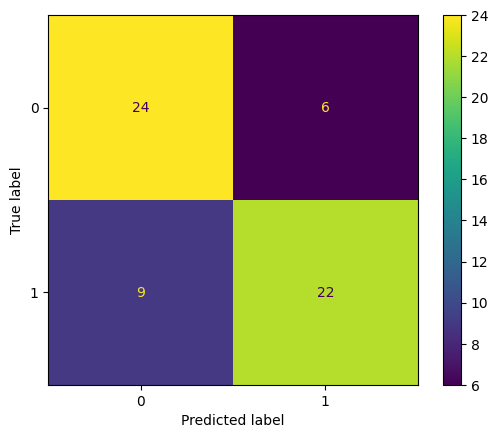

In [24]:
matrix_knn = metrics.confusion_matrix(y_test, knn1_pred)

matrix_log = metrics.confusion_matrix(y_test, prediction)
# matrix_knn, matrix_log

matrix_svm = metrics.confusion_matrix(y_test, predict_svm)

print("KNN")
disp_knn = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_knn)
disp_knn.plot()

print("Logistic")
disp_log = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_log)
disp_log.plot()

print("SVM")
disp_svm = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_svm)
disp_svm.plot()

Metrics

In [25]:
print('KNN Precision:', metrics.precision_score(y_test, knn1_pred))
print('KNN Recall:', metrics.recall_score(y_test, knn1_pred))
print('KNN Accuracy:', metrics.accuracy_score(y_test, knn1_pred))
print('KNN F1:', metrics.f1_score(y_test, knn1_pred))
print('')
print('LOG Precision:', metrics.precision_score(y_test, prediction))
print('LOG Recall:', metrics.recall_score(y_test, prediction))
print('LOG Accuracy:', metrics.accuracy_score(y_test, prediction))
print('LOG F1:', metrics.f1_score(y_test, prediction))
print('')
print('SVM Precision:', metrics.precision_score(y_test, predict_svm))
print('SVM Recall:', metrics.recall_score(y_test, predict_svm))
print('SVM Accuracy:', metrics.accuracy_score(y_test, predict_svm))
print('SVM F1:', metrics.f1_score(y_test, predict_svm))

KNN Precision: 0.8076923076923077
KNN Recall: 0.6774193548387096
KNN Accuracy: 0.7540983606557377
KNN F1: 0.7368421052631579

LOG Precision: 0.8620689655172413
LOG Recall: 0.8064516129032258
LOG Accuracy: 0.8360655737704918
LOG F1: 0.8333333333333334

SVM Precision: 0.7857142857142857
SVM Recall: 0.7096774193548387
SVM Accuracy: 0.7540983606557377
SVM F1: 0.7457627118644068


P-value analysis

In [26]:
# Import the packages
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Initiate the SelectKBest model
kbest_fc = SelectKBest(score_func=f_classif, k=5)

# Fit the model to all data
kbest_new = kbest_fc.fit(X, y)

# Check the most significant features
print('(f_classif) Most significant features: ' + str(kbest_new.get_feature_names_out()))
sorted_pvalues = list(zip(X.columns, kbest_new.pvalues_))
sorted_pvalues.sort(key=lambda tup: tup[1])
# Print 10 most significant values
for column, pvalue in sorted_pvalues[:50]:
    print(f'{column}: {pvalue}')

(f_classif) Most significant features: ['Temperature (F)_min' 'Temperature (F)_avg' 'Temperature (F)_max'
 'Humidity (%)_min' 'Humidity (%)_avg']
Temperature (F)_max: 3.534571252453644e-22
Temperature (F)_avg: 2.022333165555587e-19
Humidity (%)_min: 1.377447265595099e-16
Humidity (%)_avg: 4.278299017511215e-15
Temperature (F)_min: 1.5785303903883146e-11
Humidity (%)_max: 7.985549081210641e-07
Locations_Affected_CA: 1.366717213722277e-05
Condition__Fair: 2.0042056317093447e-05
Season_Started_Summer: 5.152741105581222e-05
Season_Started_Winter: 0.0002458184579612514
Dewpoint (F)_max: 0.0002871661878636925
Condition__Cloudy: 0.0003126861462529414
Type_Of_Location_Arctic: 0.0005531254069897448
Locations_Affected_ON: 0.0008640711504199636
Dewpoint (F)_avg: 0.001703512407733391
Type_Of_Location_Flat: 0.0034757913453155077
Locations_Affected_CO: 0.004703797613177441
Locations_Affected_NT: 0.00476712353220026
Condition__Light Rain: 0.012941899749140024
Condition__Mist: 0.019229408747062412
Loc

/home/na/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/na/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [27]:
# Import the packages
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Initiate the SelectKBest model
kbest_fr = SelectKBest(score_func=f_regression, k=1)

# Fit the model to all data
kbest_fr = kbest_fr.fit(X, y)

# Check the most significant features
print('(f_classif) Most significant features: ' + str(kbest_fr.get_feature_names_out()))
sorted_pvalues = list(zip(X.columns, kbest_fr.pvalues_))
sorted_pvalues.sort(key=lambda tup: tup[1])
# Print 10 most significant values
for column, pvalue in sorted_pvalues[:10]:
    print(f'{column}: {pvalue}')

(f_classif) Most significant features: ['Temperature (F)_max']
Temperature (F)_max: 3.5345712524527443e-22
Temperature (F)_avg: 2.022333165556486e-19
Humidity (%)_min: 1.3774472655951286e-16
Humidity (%)_avg: 4.27829901751032e-15
Temperature (F)_min: 1.5785303903883146e-11
Humidity (%)_max: 7.985549081212753e-07
Locations_Affected_CA: 1.366717213722277e-05
Condition__Fair: 2.0042056317093447e-05
Season_Started_Summer: 5.152741105581222e-05
Season_Started_Winter: 0.0002458184579612514


Lasso

In [ ]:
best_predict = 0
best_model = 0
best_score = 0
c_values = [0.0001, 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 10.0, 20.0]
# for v in c_values:
#     model_l1 = LogisticRegression(penalty='l1', C=v, solver='liblinear', max_iter=1000)
#     model_l1.fit(X_train, y_train)
#     predict = model_l1.predict(X_test)
#     score = metrics.accuracy_score(predict, y_test)
#     print(score)
#     if score > best_score:
#         best_score = score
#         best_model = model_l1
#         best_predict = predict

#Perform bootstrapping and cross-validation for each K
for v in c_values:
    accuracies = []
    model_l1 = 0
    for _ in range(25):  # Perform bootstrapping with replacement 50 times
        # Generate random indices for bootstrapping
        target_var = 'Y-Value'
        # Determining Train Test Indices with Bootstrap
        df_bootstrapped = num_stats_df.sample(n=len(num_stats_df), replace=True)
        X = df_bootstrapped.drop(columns=['Y-Value', 'Fire Name', 'Condition'])
        y = df_bootstrapped[target_var]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
        
        # Create KNN classifier with current K
        model_l1 = LogisticRegression(penalty='l1', C=v, solver='liblinear', max_iter=1000)
        model_l1.fit(X_train, y_train)
        predict = model_l1.predict(X_test)
        
        # Perform cross-validation
        scores = cross_val_score(model_l1, X, y, cv=5)
        
        # Calculate mean accuracy and store
        accuracies.append(scores.mean())

    score = np.mean(accuracies)
    print(score)
    if score > best_score:
        best_score = score
        best_model = model_l1
    
    # Calculate mean accuracy across bootstraps for current K
    mean_accuracies.append(np.mean(accuracies))


0.5222295081967213
0.7484590163934428
0.793311475409836
0.8015737704918035


In [29]:
coef = pd.DataFrame()
coef['feature_name'] = X_train.columns
coef['coefficients'] = pd.Series(([str(item) for item in best_model.coef_.reshape(X_train.shape[1], )]))
coef

,feature_name,coefficients
0,Year,-0.008351921906904225
1,Temperature (F)_min,-0.21602806481367096
2,Temperature (F)_avg,0.29837842665006314
3,Temperature (F)_max,0.009890421607926277
4,Dewpoint (F)_min,0.0458670865784402
...,...,...
106,Condition__Smoke / Windy,1.1640132792780822
107,Condition__T-Storm,5.1729575439702025
108,Condition__Thunder,-0.5880303122637813
109,Condition__Thunder in the Vicinity,0.0


In [30]:
sorted_lasso = list(zip(X.columns, best_model.coef_.reshape(X_train.shape[1], )))
sorted_lasso.sort(key=lambda tup: abs(tup[1]) if tup[1] != 0.0 else -100.0, reverse=True)
# Print 10 most significant values
for column, las in sorted_lasso[:30]:
    print(f'{column}: {las}')

Condition__T-Storm: 5.1729575439702025
Locations_Affected_NC: 5.153596392470174
Type_Of_Location_Arctic: -3.430430086180882
Locations_Affected_NY: -3.3416210987970487
Condition__N/A: -3.2162501331215365
Type_Of_Location_Grasslands: 3.198678698934261
Locations_Affected_MI: 3.1801207548577217
Condition__Haze: 3.0460904174139496
Locations_Affected_YT: 2.996815216306046
Locations_Affected_CO: 2.956818020664004
Type_Of_Location_Flat: -2.9447673447513205
Locations_Affected_DK: -2.888883697749209
Locations_Affected_MT: 2.766095809498289
Type_Of_Location_Desert: 2.6265631450844213
Locations_Affected_CA: 2.5037817521419052
Locations_Affected_TX: -2.1004050291238707
Locations_Affected_AZ: -2.0952425518162663
Condition__Drifting Snow: -2.0092104960434214
Locations_Affected_DC: 1.9209182017303335
Type_Of_Location_Rainforest: 1.5899385061584883
Condition__Light Rain with Thunder: -1.372329563172393
Locations_Affected_OR: 1.2823816502862837
Season_Started_Fall: -1.280982080800789
Condition__Cloudy /

In [31]:
sorted_pvalues = list(zip(X.columns, kbest_fr.pvalues_))
sorted_pvalues.sort(key=lambda tup: tup[1], reverse=True)
# Print 10 most significant values
for column, pvalue in sorted_pvalues[:10]:
    print(f'{column}: {pvalue}')

Percipitation (in)_min: 1.0
Condition__T-Storm: 0.9815163981816177
Condition__Cloudy / Windy: 0.9684280846881876
Locations_Affected_TX: 0.9677778812022378
Condition__Partly Cloudy: 0.9596788060399295
Locations_Affected_YT: 0.953979792147328
Locations_Affected_MB: 0.9023433573710379
Condition__Smoke: 0.9022442246036125
Type_Of_Location_Mountains: 0.8877744557726188
Type_Of_Location_Coastal Mountain: 0.8576844003668944


In [32]:
matrix_log = metrics.confusion_matrix(y_test, best_predict)

disp_la = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_log)
disp_la.plot()

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 0 instead.

### Feature scaling

TBD

### Data visualization

TBD